### Keras DNN으로 집값 예측하기

1. 패키지 수입 및 하이퍼 파라미터 지정

In [ ]:
# 수입
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 
# 대부분의 alias는 모듈을 만든 사람이 처음 사용하던 별명과 동일하게 사용
from time import time

from keras.models import Sequential
from keras.layers import Dense
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [ ]:
# 하이퍼 파라미터
MY_HIDDEN = 1000
MY_EPOCH = 500

# print()할 때 column 데이터가 생략되는 것 방지
pd.set_option('display.max_columns', None)

2. 데이터 불러 오기 및 선처리

In [ ]:
# 데이터 파일 읽기 
raw = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/housing.csv') # read_csv : csv 파일을 읽어라

# 데이터 샘플 10개 출력
print(raw.head(10)) # 처음 10개의 데이터 불러옴

# 원본 데이터 통계
print(raw.describe())

      CRIM    ZN  INDUS  CHAS    NOX     RM    AGE     DIS  RAD  TAX  PTRATIO  \
0  0.00632  18.0   2.31     0  0.538  6.575   65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421   78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185   61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998   45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147   54.2  6.0622    3  222     18.7   
5  0.02985   0.0   2.18     0  0.458  6.430   58.7  6.0622    3  222     18.7   
6  0.08829  12.5   7.87     0  0.524  6.012   66.6  5.5605    5  311     15.2   
7  0.14455  12.5   7.87     0  0.524  6.172   96.1  5.9505    5  311     15.2   
8  0.21124  12.5   7.87     0  0.524  5.631  100.0  6.0821    5  311     15.2   
9  0.17004  12.5   7.87     0  0.524  6.004   85.9  6.5921    5  311     15.2   

   LSTAT  MEDV  
0   4.98  24.0  
1   9.14  21.6  
2   4.03  34.7  
3   2.94  33.4  
4   5.33  36.2  
5   5.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


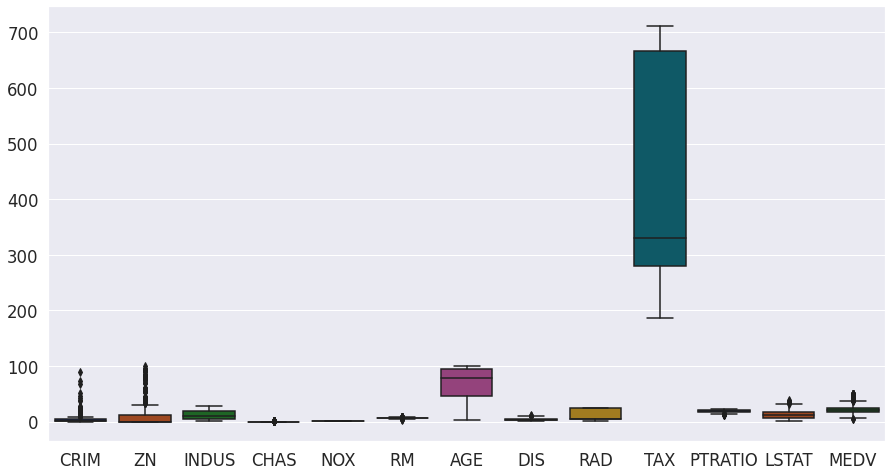

In [ ]:
# 15X8 차트를 그림
plt.figure(figsize=(15, 8))

sns.set(font_scale=1.5)
# Box plot : 자료의 5가지 요약 수치를 표현(min, max, outliers, IQR, median)
#            중심부로부터의 데이터 밀집도 파악
# 특이점이 많으면 정확도 떨어짐!
sns.boxplot(data=raw, palette='dark')

In [ ]:
# z-점수 정규화
scaler = StandardScaler()

z_data = scaler.fit_transform(raw)

# 데이터 형식 출력
print(type(raw)) # panda : 2차원 테이블
print(type(z_data)) # numpy : n차원 행렬

# numpy를 pandas로 재전환
z_data = pd.DataFrame(z_data)
print(type(z_data))

# z-점수 정규화 된 데이터 샘플 출력
# z-점수 정규화는 모든 데이터의 표준편차를 1, 평균을 0으로 맞춤.
# 모든 요소들의 범위가 비슷해짐 = 표준 정규 분포
print(z_data.head(10))
print(z_data.describe())

<class 'pandas.core.frame.DataFrame'>
<class 'numpy.ndarray'>
<class 'pandas.core.frame.DataFrame'>
         0         1         2         3         4         5         6   \
0 -0.419782  0.284830 -1.287909 -0.272599 -0.144217  0.413672 -0.120013   
1 -0.417339 -0.487722 -0.593381 -0.272599 -0.740262  0.194274  0.367166   
2 -0.417342 -0.487722 -0.593381 -0.272599 -0.740262  1.282714 -0.265812   
3 -0.416750 -0.487722 -1.306878 -0.272599 -0.835284  1.016303 -0.809889   
4 -0.412482 -0.487722 -1.306878 -0.272599 -0.835284  1.228577 -0.511180   
5 -0.417044 -0.487722 -1.306878 -0.272599 -0.835284  0.207096 -0.351157   
6 -0.410243  0.048772 -0.476654 -0.272599 -0.265154 -0.388411 -0.070229   
7 -0.403696  0.048772 -0.476654 -0.272599 -0.265154 -0.160466  0.978808   
8 -0.395935  0.048772 -0.476654 -0.272599 -0.265154 -0.931206  1.117494   
9 -0.400729  0.048772 -0.476654 -0.272599 -0.265154 -0.399808  0.616090   

         7         8         9         10        11        12  
0  0.14021

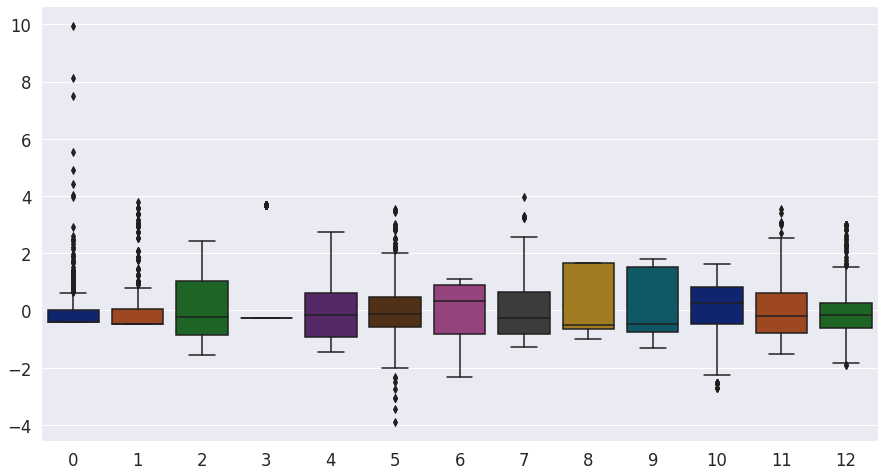

In [ ]:
# 15X8 차트를 그림
plt.figure(figsize=(15, 8))

sns.set(font_scale=1.5)
# Box plot : 자료의 5가지 요약 수치를 표현(min, max, outliers, IQR, median)
#            중심부로부터의 데이터 밀집도 파악
sns.boxplot(data=z_data, palette='dark')

In [ ]:
# 데이터 모양(행-동네 개수, 열-영향 요소) 출력
print('분리 전 :',z_data.shape)

# 데이터를 입력(집값 제외 column)과 출력(집값)으로 분리
# z-정규화로 인해 열 명이 숫자로 변환됨. 열 명은 숫자로 해야함! 
x_data = z_data.drop(12,axis=1) # 12번 째(집값) 열을 드롭시킴
y_data = z_data[12] # 출력

# 데이터 모양 출력
print('분리 후 : ', end="")
print(x_data.shape, end=", ")
print(y_data.shape) # 1차원 벡터를 표현하는 튜플이기 때문에 열이 공백으로 표현

분리 전 : (506, 13)
분리 후 : (506, 12), (506,)


In [ ]:
# 데이터 4분할
x_train, x_test,y_train, y_test = train_test_split(x_data,
                                                   y_data,
                                                   train_size=0.7)

# 최종 데이터 모양 출력
print('학습용 입력 데이터 모양 :', x_train.shape)
print('학습용 출력 데이터 모양 :', y_train.shape)
print('평가용 입력 데이터 모양 :', x_test.shape)
print('평가용 출력 데이터 모양 :', y_test.shape)

학습용 입력 데이터 모양 : (354, 12)
학습용 출력 데이터 모양 : (354,)
평가용 입력 데이터 모양 : (152, 12)
평가용 출력 데이터 모양 : (152,)


3. 인공 신경망 구현

In [ ]:
# 왼쪽에서 오른쪽으로 순차적으로 신경망 추가
# GAN에선 Sequential 사용 x
model = Sequential()

input = x_train.shape[1] # x_train의 모양 정보 중 2번째 (12)

# 입력층과 은닉층 1 추가 / Dense(뉴런 개수, 입력층, 활성화 함수)
# 활성화 함수 : 뉴런의 최종 출력값 필터링(선형 모델을 비선형으로 바꿔줌)
# relu : 음수를 0으로
model.add(Dense(units=MY_HIDDEN,
                input_dim=input,
                activation='softmax'))

# 은닉층 2 추가
model.add(Dense(units=MY_HIDDEN,
                activation='softmax'))

# 출력층 추가
model.add(Dense(units=1))

print('* DNN 요약 *')
# Dense = fully conected : 완전 연결된 층들 사이의 선이 몇개인지
# param 1 : 가중치(12000) + 편향(1000)
# param 2 : 가중치(1000000) + 편향(1000)
# param 3 : 가중치(1000) + 편향(1)
model.summary()

* DNN 요약 *
Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_25 (Dense)             (None, 1000)              13000     
_________________________________________________________________
dense_26 (Dense)             (None, 1000)              1001000   
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 1001      
Total params: 1,015,001
Trainable params: 1,015,001
Non-trainable params: 0
_________________________________________________________________


4. 인공 신경망 학습

In [ ]:
# 학습 환경 설정
# compile(최적 함수, 손실 함수)
model.compile(optimizer='rmsprop',
              loss='mse')

print('학습 시작')
begin = time()

# 500번의 반복 학습, verbose를 0으로 하면 학습 상황을 출력하지 않음
model.fit(x=x_train,
          y=y_train,
          epochs=MY_EPOCH,
          verbose=0)

end = time()
# GPU 쓰면 학습 시간 빨라짐
print('총 학습 시간 : {:.2f}초'.format(end - begin))

학습 시작
총 학습 시간 : 11.72초


5. 인공 신경망 평가

In [ ]:
# 신경망 평가
loss = model.evaluate(x=x_test,
                      y=y_test,
                      verbose=0)

# 소수점 이하 둘째 자리까지 출력
print('최종 손실값 : {:.2f}'.format(loss))

최종 손실값 : 0.10


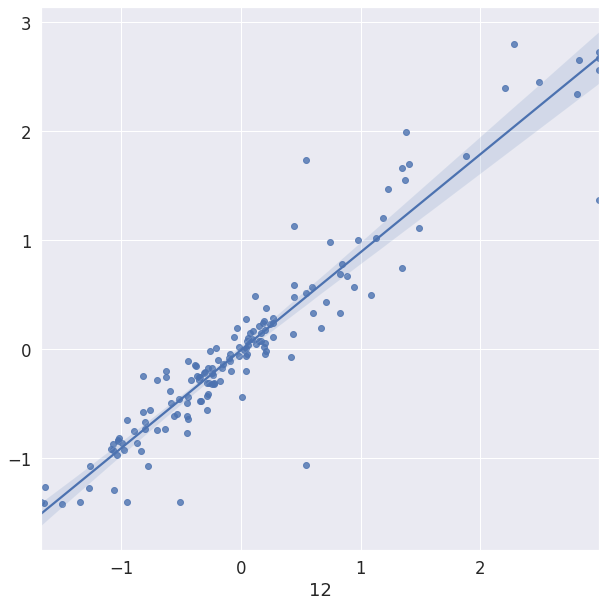

In [ ]:
# DNN으로 예측
pred = model.predict(x=x_test)
plt.figure(figsize=(10, 10))

sns.regplot(x=y_test, y = pred)
# 산포도가 정비례로 표현 : 정답과 모델이 추측한 값이 거의 비슷함
# 인공지능의 회귀문제를 풀 때. 인공신경망의 정홛로를 시각화 하기 위해 산포도를 주로 사용